# infer luminosity function for `mock0`

$$p(\phi\,|\,\{X_i\},S) \approx p(\phi\,|\,S) \prod\limits_{i=1}^{N} \frac{1}{M} \sum\limits_{j=1}^M \frac{p(\theta_{ij}\,|\,\phi, S)}{p(\theta_{ij}\,|\,S)}$$

In [1]:
import os
import numpy as np 

In [2]:
from scipy import integrate

In [3]:
import emcee

In [4]:
# --- plotting --- 
import corner as DFM
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

# read `mock0` observations

In [5]:
_, _, mock_photoz, mock_Muv, mock_photoz_1sig, mock_Muv_1sig, w_z, w_muv = np.loadtxt('/Users/chahah/data/binsin/mock0.dat',
                                                                    unpack=True, skiprows=1)

In [6]:
w_select = w_z * w_muv

(-14.0, -22.0)

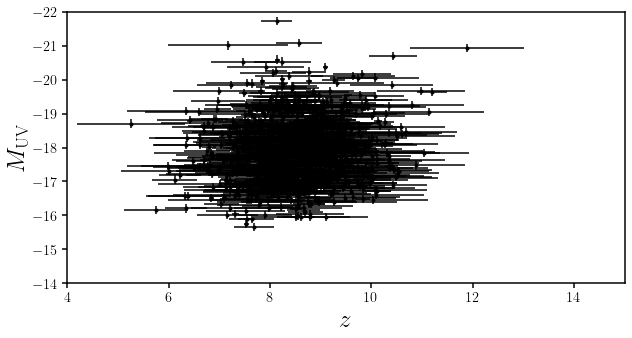

In [7]:
fig = plt.figure(figsize=(10,5))
sub = fig.add_subplot(111)
sub.errorbar(mock_photoz, mock_Muv, xerr=mock_photoz_1sig, yerr=mock_Muv_1sig, fmt='.k')
sub.set_xlabel(r'$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_xlim(4, 15)
sub.set_ylim(-14, -22)

# derive individual posteriors $p(M_{\rm UV}, z\,|\,X_i)$

In [10]:
n_mcmc = 1000
posteriors = np.zeros((len(mock_photoz), 2, n_mcmc))
posteriors[:,0,:] = (mock_photoz[:,None] + mock_photoz_1sig[:,None] * np.random.normal(size=(len(mock_photoz), n_mcmc))).clip(4., 15)
posteriors[:,1,:] = (mock_Muv[:,None] + mock_Muv_1sig[:,None] * np.random.normal(size=(len(mock_photoz), n_mcmc))).clip(-22., -15.)

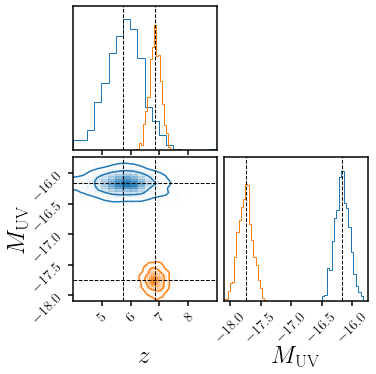

In [11]:
fig = DFM.corner(posteriors[0,:,:].T, levels=[0.68, 0.95], smooth=True, color='C0')
DFM.overplot_lines(fig, [mock_photoz[0], mock_Muv[0]], color='k', linestyle='--', linewidth=1)

for i, igal in enumerate([3]):
    _ = DFM.corner(posteriors[igal,:,:].T, 
                   labels=['$z$', r'$M_{\rm UV}$'], label_kwargs={'fontsize': 25}, 
                   levels=[0.68, 0.95], smooth=True, color='C%i' % (i+1), fig=fig)
    DFM.overplot_lines(fig, [mock_photoz[igal], mock_Muv[igal]], color='k', linestyle='--', linewidth=1)

# set up $p(\theta\,|\,\phi,S)$
$$\Phi(M_{\rm UV}, z) = \frac{\Phi^* 10^{\gamma(z - 9)}}{10^{0.4(\alpha+1)(M_{\rm UV}-M^*)} + 10^{0.4(\beta+1)(M_{\rm UV}-M^*)}}$$

In [12]:
def LF(Muv, z, phi): 
    #Muv_s = -19.5
    alpha, beta, gamma, Muv_s = phi
    return (10**(gamma * (z - 9.)))/(10**(0.4*(alpha + 1)*(Muv - Muv_s) + 10**(0.4*(beta + 1)*(Muv - Muv_s))))

# set up $p(\theta\,|\,S)$

In [13]:
bx = np.load('/Users/chahah/data/binsin/mock0_selection.bx.npy')
by = np.load('/Users/chahah/data/binsin/mock0_selection.by.npy')
ptS = np.load('/Users/chahah/data/binsin/mock0_selection.p_theta_S.npy')

def p_theta_S(Muv, z): 
    i_x = np.digitize(Muv, by)
    i_y = np.digitize(z, bx)
    return ptS[i_x-1, i_y-1]

(-15.0, -22.0)

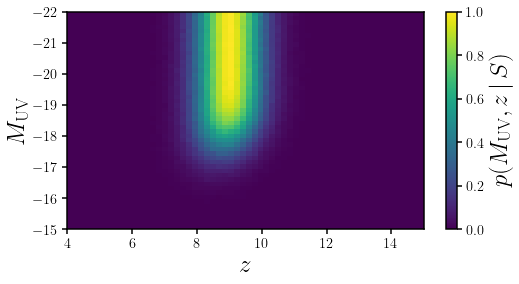

In [14]:
fig = plt.figure(figsize=(8,4))
sub = fig.add_subplot(111)
X, Y = np.meshgrid(bx, by)

p = sub.pcolormesh(X, Y, ptS, vmin=0., vmax=1)

plt.colorbar(p).set_label(r'$p(M_{\rm UV}, z\,|\,S)$', size=25)
sub.set_xlabel('$z$', fontsize=25)
sub.set_ylabel(r'$M_{\rm UV}$', fontsize=25)
sub.set_ylim(-15, -22)

# set up full posterior
$$p(\phi\,|\,\{X_i\},S) \approx p(\phi\,|\,S) \prod\limits_{i=1}^{N} \frac{1}{M} \sum\limits_{j=1}^M \frac{p(\theta_{ij}\,|\,\phi, S)}{p(\theta_{ij}\,|\,S)}$$
$$\log p(\phi\,|\,\{X_i\},S) \approx {\rm constant} + \log p(\phi\,|\,S) + \sum\limits_{i=1}^{N} \log \sum\limits_{j=1}^M \frac{\Phi(\theta_{ij};\phi,S)/\int\Phi(\theta';\phi){\rm d}\theta}{p(\theta_{ij}\,|\,S)}$$

In [15]:
post_S = p_theta_S(posteriors[:,1,:], posteriors[:,0,:])
within = (np.sum(post_S, axis=1) > 0)

In [16]:
unif = np.array([4., -22])[None,:] + np.array([10, 7])[None,:] * np.random.uniform(size=(100000, 2))
unif_S = p_theta_S(unif[:,1], unif[:,0])

In [21]:
def log_prior(phi): 
    alpha, beta, gamma, Muv_s = phi
    if -3. < alpha < 3. and -3. < beta < 3. and -2. < gamma < 1 and -22 < Muv_s < -15: 
        return 0.
    return -np.inf

def log_posterior(phi): 
    lp = log_prior(phi)
    if not np.isfinite(lp):
        return -np.inf
    
    Phi = LF(posteriors[:,1,:], posteriors[:,0,:], phi)
    norm_Phi = np.sum(LF(unif[:,1], unif[:,0], phi) * unif_S)

    p_Xi_phiS = np.sum(Phi * post_S / norm_Phi, axis=1)
    
    logp = np.sum(np.log(p_Xi_phiS)[within] - np.log(w_select)[within], axis=0)
    if np.isnan(logp): raise ValueError
    return logp

In [22]:
log_posterior([-1.65, -1.5, -0.2, -19.5]), log_posterior([-1.5,  -1.33, -0.2, -17.98954929]), log_posterior([-1.21126749, -1.39672104, -0.14763412, -19.5]), log_posterior([-0.001, -1.45, -0.05, -20]), log_posterior([-2.99, -2.8, -0.98, -19])

(-1229.778350600337,
 -1229.0065334960266,
 -1341.435943439239,
 -2661.5105961401605,
 -3139.2788666478054)

In [23]:
%timeit log_posterior([-1.21126749, -1.39672104, -0.14763412, -19.5])

85 ms ± 6.53 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [24]:
ndim, nwalkers = 4, 20
var = np.array([0.1, 0.1, 0.1, 0.1])
p0 = np.array([-1.6, -1.4, -0.15, -19.4])[None,:] + var[None,:]*np.random.randn(nwalkers, ndim)

In [25]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
_ = sampler.run_mcmc(p0, 1000, progress=True)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [24:34<00:00,  1.47s/it]


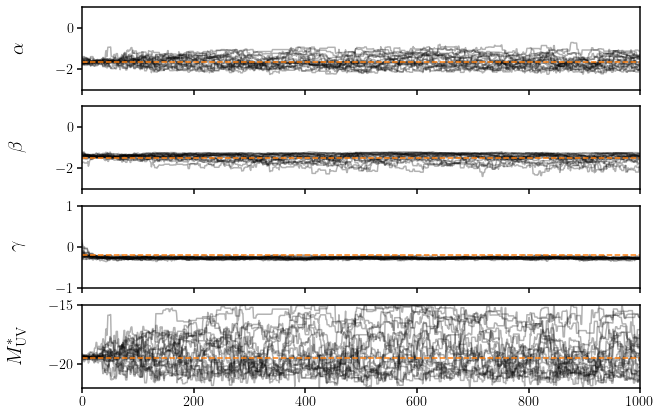

In [26]:
phi_true = np.array([-1.65, -1.5, -0.2, -19.5])

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.plot([0, samples.shape[0]], [phi_true[i], phi_true[i]], c='C1', ls='--')
    ax.set_xlim(0, len(samples))
    ax.set_ylabel([r'$\alpha$', r'$\beta$', r'$\gamma$', r'$M_{\rm UV}^*$'][i], fontsize=20)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_ylim([(-3., 1.), (-3., 1.), (-1., 1.), (-22, -15)][i])

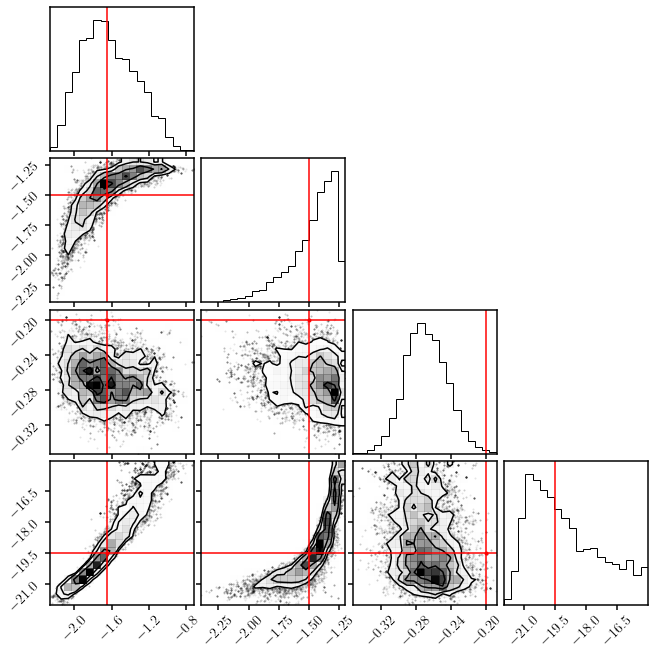

In [29]:
fig = DFM.corner(sampler.flatchain[1000:,:])
DFM.overplot_points(fig, [phi_true], color='red')
DFM.overplot_lines(fig, phi_true, color='red')

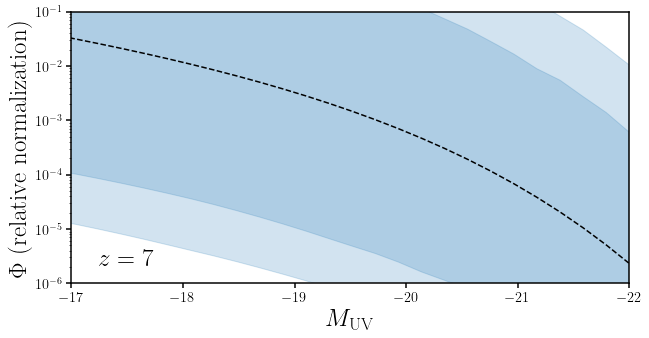

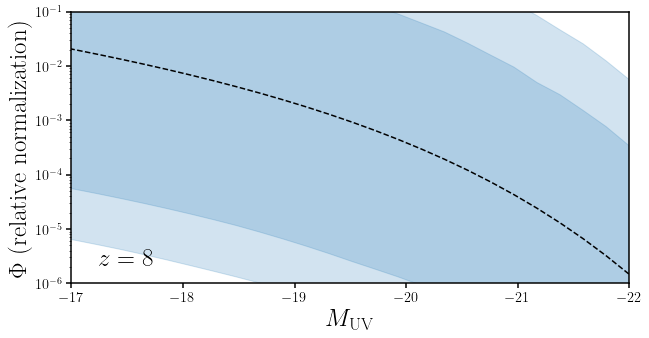

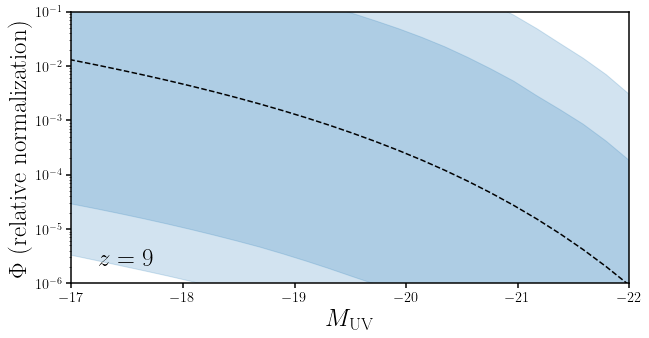

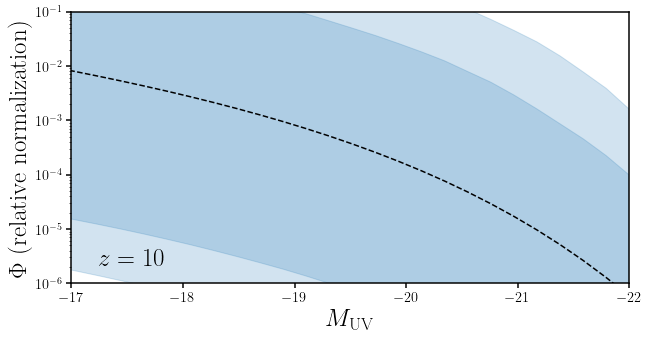

In [30]:
phi_amp = 6e-3
phi_true = np.array([-1.65, -1.5, -0.2, -19.5]) # fit by eye to zeus21 output
norm_Phi_true = np.sum(LF(unif[:,1], unif[:,0], phi_true) * unif_S)

muv = np.linspace(-16, -22, 30)

for z in [7, 8, 9, 10]: 
    fig = plt.figure(figsize=(10,5))
    sub = fig.add_subplot(111)

    lf = phi_amp * LF(muv, z, phi_true)
    
    lfs = []
    for phi in sampler.flatchain[nwalkers*-200:,:]:
        _phi_amp = phi_amp / norm_Phi_true * np.sum(LF(unif[:,1], unif[:,0], phi) * unif_S)
        lfs.append(_phi_amp * LF(muv, z, phi))

    phi_med = np.median(sampler.flatchain[nwalkers*-100:,:], axis=0)
    
    q0, q1, q2, q3 = np.quantile(np.array(lfs), [0.025, 0.16, 0.84, 0.975], axis=0)

    sub.fill_between(muv, q0, q3, color='C0', alpha=0.2)
    sub.fill_between(muv, q1, q2, color='C0', alpha=0.2)
    sub.plot(muv, lf, c='k', ls='--')
    
    sub.text(0.05, 0.05, r'$z=%.f$' % z, fontsize=25, transform=sub.transAxes, ha='left', va='bottom')
    sub.set_xlabel(r'$M_{\rm UV}$', fontsize=25)
    sub.set_xlim(-17, -22)
    sub.set_ylabel(r'$\Phi$ (relative normalization)', fontsize=25)
    sub.set_yscale('log')
    sub.set_ylim(1e-6, 1e-1)#sub.set_ylim(0.1, 4e2)
    #sub.set_ylim(0.1, 4e2)